# Use torch.nn.RNN module

In [34]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
import torchvision.models as models
import torchvision.utils as vutils
from torchvision import datasets
%matplotlib inline

In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import unicodedata
import string
import torch.nn as nn
import torch

In [3]:
def findFiles(path): return glob.glob(path)

In [4]:
print(findFiles('../data/names/*.txt'))

['../data/names\\Arabic.txt', '../data/names\\Chinese.txt', '../data/names\\Czech.txt', '../data/names\\Dutch.txt', '../data/names\\English.txt', '../data/names\\French.txt', '../data/names\\German.txt', '../data/names\\Greek.txt', '../data/names\\Irish.txt', '../data/names\\Italian.txt', '../data/names\\Japanese.txt', '../data/names\\Korean.txt', '../data/names\\Polish.txt', '../data/names\\Portuguese.txt', '../data/names\\Russian.txt', '../data/names\\Scottish.txt', '../data/names\\Spanish.txt', '../data/names\\Vietnamese.txt']


In [5]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [6]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [7]:
n_letters

57

In [8]:
import unidecode
print(unidecode.unidecode('Ślusàrski'))

Slusarski


In [9]:
print(unidecode.unidecode('嬴政'))

Ying Zheng 


In [10]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [11]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

In [12]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('../data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0].split('\\')[-1]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [13]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [14]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
torch.Size([5, 1, 57])


In [15]:
print(letterToTensor('J'))

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


In [16]:
print(lineToTensor('Jones').size())

torch.Size([5, 1, 57])


Creating the Network
====================

Training
========
Preparing for Training
----------------------

In [17]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

#print(categoryFromOutput(output))

In [18]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Korean / line = Baik
category = Russian / line = Yakush
category = Polish / line = Gorka
category = Czech / line = Kirchma
category = English / line = Lenihan
category = Scottish / line = Muir
category = Spanish / line = Arce
category = Russian / line = Bairov
category = Polish / line = Piatek
category = English / line = Carling


Plotting the Results
--------------------

In [19]:
>>> rnn = nn.RNN(10, 20, 2)
>>> input = torch.randn(5, 3, 10)
>>> h0 = torch.randn(2, 3, 20)
>>> output, hn = rnn(input, h0)

In [20]:
>>> rnn = nn.RNN(53, 100, 1)
>>> input = torch.randn(5, 1, 53)
>>> h0 = torch.randn(1, 1, 100)
>>> output, hn = rnn(input, h0)

In [21]:
input.shape

torch.Size([5, 1, 53])

In [22]:
h0.shape

torch.Size([1, 1, 100])

In [23]:
torch.sum(output[4,:,:] == hn)

tensor(100)

In [24]:
hn

tensor([[[ 0.6875, -0.0848, -0.1771,  0.3073,  0.2032,  0.5270,  0.0340,
           0.6789,  0.0326,  0.2766, -0.4016, -0.5675,  0.0030, -0.2642,
           0.5215,  0.2366, -0.3060, -0.6604, -0.0679, -0.3550, -0.3706,
           0.4017,  0.1543, -0.2203,  0.6906, -0.0363, -0.2849,  0.4081,
          -0.3639,  0.3089,  0.5007,  0.4623, -0.0270,  0.1920,  0.1126,
          -0.1918,  0.0371, -0.2708, -0.5903, -0.0703,  0.5380,  0.1659,
           0.7010,  0.1429, -0.5267,  0.6990, -0.4435, -0.1094, -0.1266,
           0.0821, -0.2602,  0.0134,  0.1954,  0.5655, -0.3198, -0.7245,
           0.2898,  0.2801, -0.0260,  0.2995,  0.2012, -0.2758, -0.0893,
           0.2750, -0.4089,  0.4543,  0.2900, -0.0374,  0.1472,  0.1486,
           0.3546, -0.3648, -0.2702,  0.2046,  0.2994,  0.5531,  0.1360,
          -0.5355,  0.4266, -0.3971,  0.3914,  0.3809,  0.1545, -0.3166,
           0.0305, -0.5141, -0.1929,  0.2190, -0.1087, -0.0445, -0.0586,
          -0.0028, -0.0393, -0.0736, -0.5491,  0.01

In [25]:
class nn_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, X, hidden):
        _, hidden = self.rnn(X, hidden)
        output = self.out(hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [26]:
category, line, category_tensor, line_tensor = randomTrainingExample()

In [39]:
rnn = nn_RNN(n_letters, 128, n_categories)

In [40]:
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.RMSprop(rnn.parameters(), lr=0.001)
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.005)

In [41]:
output, hidden = rnn(line_tensor, hidden)

NameError: name 'hidden' is not defined

In [42]:
output.view(n_categories)

tensor([ 0.7333, -0.8476,  1.1089, -0.0896,  0.6844,  0.2115, -0.9852,
        -0.3950,  1.5081, -2.4685, -1.5561, -0.1898,  1.2716, -1.6225,
         1.8750,  1.6550, -1.1549, -0.0907])

In [43]:
category_tensor

tensor([ 10])

In [44]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    optimizer.zero_grad()

    output, hidden = rnn(line_tensor, hidden)

    loss = criterion(output.view(-1,n_categories), category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    
    optimizer.step()

    return output, loss.item()

In [45]:
writer = SummaryWriter('logs/rnn1')

In [46]:
import time
import math

n_iters = 500000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(0, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        writer.add_scalar('loss', current_loss / plot_every, iter)
        current_loss = 0

0 0% (0m 0s) 2.9361 Kelly / German ✗ (Scottish)
5000 1% (0m 20s) 2.0110 Sung / Vietnamese ✗ (Korean)
10000 2% (0m 33s) 2.2216 Palmeiro / Italian ✗ (Portuguese)
15000 3% (0m 49s) 2.2668 Ochida / Spanish ✗ (Japanese)
20000 4% (0m 58s) 1.3541 Yep / Vietnamese ✗ (Chinese)
25000 5% (1m 43s) 0.5822 Seighin / Irish ✓
30000 6% (1m 52s) 2.0638 Richard / French ✗ (Dutch)
35000 7% (2m 1s) 1.0075 Metjeka / Japanese ✗ (Czech)
40000 8% (2m 10s) 2.5009 D'cruze / French ✗ (Portuguese)
45000 9% (2m 19s) 0.5353 Zhan / Chinese ✓
50000 10% (2m 27s) 0.3490 Dang / Vietnamese ✓
55000 11% (2m 39s) 0.2062 Chellos / Greek ✓
60000 12% (2m 54s) 4.3179 Maceachthighearna / Spanish ✗ (Irish)
65000 13% (3m 7s) 3.3675 Easterbrook / Czech ✗ (English)
70000 14% (3m 20s) 0.1615 Pasternack / Polish ✓
75000 15% (3m 32s) 0.5578 Ngo / Vietnamese ✓
80000 16% (3m 52s) 2.4394 Schenck / Czech ✗ (Dutch)
85000 17% (4m 31s) 0.0197 O'Byrne / Irish ✓
90000 18% (5m 6s) 0.0415 Than / Vietnamese ✓
95000 19% (5m 22s) 0.2080 Vinh / Vietna

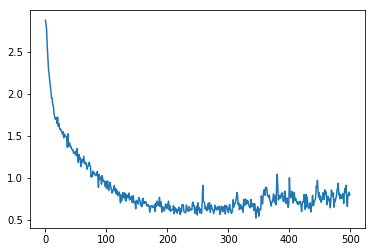

In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses[1:])

In [48]:
def predict_max(model, X):
    hidden = model.initHidden()
    y_score, hidden = model(X, hidden)
    
    return torch.max(y_score, 2)[1][0]

In [49]:
def calc_accuracy(model, num_samples=10000):
    num_corrects = 0
    for i in range(num_samples):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        #print(line)
        y_pred = predict_max(model, line_tensor)
        #print(f'y_pred:{y_pred}, y:{category_tensor}')
        num_corrects += (category_tensor.item() == y_pred.item())
        
    return num_corrects/num_samples
        

In [50]:
calc_accuracy(rnn)

0.7447

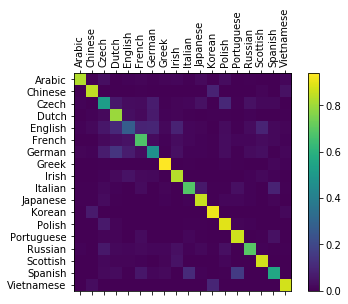

In [51]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()    
    output, hidden = rnn(line_tensor, hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.figure(figsize=(10,8))
plt.show()

In [100]:
output = evaluate(lineToTensor('Dovesky'))

In [101]:
output

tensor([[[-5.8003, -5.8330,  7.4291,  3.6712,  5.6942,  2.2835,  3.0768,
           0.1592,  2.1919, -1.5685, -2.9600, -2.1272,  2.0514, -6.8787,
           6.9176,  4.3102, -2.0898, -7.5248]]])

In [104]:
output.shape

torch.Size([1, 1, 18])

In [107]:
topv, topi = output.topk(3, 2, True)

In [111]:
topv[0,0][0]

tensor(7.4291)

In [112]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 2, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0,0][i].item()
            category_index = topi[0,0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(7.43) Czech
(6.92) Russian
(5.69) English

> Jackson
(8.61) Scottish
(4.54) English
(4.36) Czech

> Satoshi
(5.55) Japanese
(5.55) Italian
(3.28) Polish


In [113]:
predict('Fan')


> Fan
(4.51) Chinese
(2.76) Korean
(2.00) Irish


In [114]:
predict('Wang')


> Wang
(7.18) Chinese
(5.20) Korean
(3.92) Scottish


In [115]:
predict('Qin')


> Qin
(7.42) Chinese
(5.72) Korean
(2.94) Vietnamese
